<h1> ECE4179 - Semi-Supervised Learning Project</h1>
<h2>Data</h2>

We will be using a dataset that can be obtained directly from the torchvision package. There are 10 classes and we will be training a CNN for the image classification task. We have training, validation and test sets that are labelled with the class, and a large unlabeled set.

We will simulating a low training data scenario by only sampling a small percentage of the labelled data (10%) as training data. The remaining examples will be used as the validation set.

To get the labelled data, change the dataset_dir to something suitable for your machine, and execute the following (you will then probably want to wrap the dataset objects in a PyTorch DataLoader):

In [1]:
import torch
from torchvision.datasets import STL10 as STL10
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
import os
import time


####### CHANGE TO APPROPRIATE DIRECTORY TO STORE DATASET
dataset_dir = os.getcwd()+"/CNN-VAE/data"
#For MonARCH
# dataset_dir = "/mnt/lustre/projects/ds19/SHARED"

#All images are 3x96x96
image_size = 96
#Example batch size
batch_size = 32
# Number of classes for classification
out_classes = 10

save_dir = 'Models'
#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
# Hardware acceleration
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

<h3>Create the appropriate transforms</h3>

In [2]:
#Perform random crops and mirroring for data augmentation
transform_train = transforms.Compose(
    [transforms.RandomCrop(image_size, padding=4),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ])

transform_unlabelled = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ])

#No random 
transform_test = transforms.Compose(
    [transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ])


<h3>Create training and validation split</h3>

In [3]:
#Load train and validation sets
trainval_set = STL10(dataset_dir, split='train', transform=transform_train, download=True)

#Use 10% of data for training - simulating low data scenario
num_train = int(len(trainval_set)*0.1)

#Split data into train/val sets
torch.manual_seed(0) #Set torch's random seed so that random split of data is reproducible
train_set, val_set = random_split(trainval_set, [num_train, len(trainval_set)-num_train])

#Load test set
test_set = STL10(dataset_dir, split='test', transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


<h3>Get the unlabelled data</h3>

In [4]:
#unlabelled_set = STL10(dataset_dir, split='unlabeled', transform=transform_unlabelled, download=True)

You may find later that you want to make changes to how the unlabelled data is loaded. This might require you sub-classing the STL10 class used above or to create your own dataloader similar to the Pytorch one.
https://pytorch.org/docs/stable/_modules/torchvision/datasets/stl10.html#STL10

<h3>Create the four dataloaders</h3>

In [5]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
#unlabelled_loader = DataLoader(unlabelled_set, shuffle=True, batch_size=batch_size)

valid_loader = DataLoader(val_set, batch_size=batch_size)
test_loader  = DataLoader(test_set, batch_size=batch_size)

### Generic train and eval/test

In [6]:
# Code is modifed from the recomened training method https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html refured to from the project discription

def train_model(model, dataloaders, criterion, optimizer, save_path, num_epochs=25, is_test = False, is_unlabelled = False):
    """
    Trains the model

    Parameters
    ----------
    model : pytorch net
    dataloaders : [DataLoader]
        list of dataloaders. Train the val loader
    criterion : torch.nn
    optimizer : torch.optim
    save_path : str
        save path for the model
    num_epochs : int, optional
    is_test : bool, optional
        if True then give dataloaders a list with a single Dataloader and will run it with a validation method
    is_unlabelled : bool, optional
        if True pass give dataloaders a list with a single Dataloader and will run it with a train method

    Returns
    -------
    best_acc
        best validation accuracy
    best_epoch
        epoch at best validation accuracy
    train_acc_history
    train_loss_history
    val_acc_history
    val_loss_history
    """
    start = time.time()

    # Phases in same order as dataloaders list -> [train_loader, val_loader]
    phases = ['train', 'val']

    """Use a method like this to add custom learning methods if needed"""
    # If round is for testing only do 1 epoch and run it in validation 
    if is_test:
        num_epochs = 1
        phases = ['test']

    """Example added dataset, dataloaders->[unlabelled_loader]"""
    forceSave = False
    if is_unlabelled:
        phases = ['train']
        forceSave = True

    # Keep track of stats
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch: [%2d/%d]' %(epoch+1, num_epochs), end='')

        # Each epoch has a training and validation phase
        for ip, phase in enumerate(phases):
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[ip]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Epoch loss and epoch acc as %
            epoch_loss = running_loss / len(dataloaders[ip].dataset)
            epoch_acc = (running_corrects.double() / len(dataloaders[ip].dataset))*100

            print(' [ phase: %s | Loss: %5.4f | Acc: %5.2f%% ]' %(phase, epoch_loss, epoch_acc), end='')

            # Save the model
            if (phase == 'val' and epoch_acc > best_acc) or forceSave:
                torch.save(model.state_dict(), save_path)

            # Get the best acc and epoch
            if (phase == 'val' or phase == 'test') and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc

            # Log epoch data
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

            # Fill val logging with test data if applicable
            if phase == 'val' or phase == 'test':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        # Seperate lines
        print()

    time_elapsed = time.time() - start
    print('Best val Acc: %.4f%% @ epoch %d' %(best_acc, best_epoch+1))
    print('Elapsed time: %.0f:%.0f' %(time_elapsed//60, time_elapsed%60))
    print()

    return best_acc, best_epoch, train_acc_history, train_loss_history, val_acc_history, val_loss_history

## Network

Let's use a ResNet18 architecture for our CNN...

In [7]:
# Create resnet and change to output 109 different classes 
net = torchvision.models.resnet18(pretrained=False).to(device)
net_fc_in = net.fc.in_features
net.fc = nn.Linear(net_fc_in, out_classes).to(device)

In [8]:
### Hyper paramaters
num_epochs = 30
lr = 1e-4
optimizer =  torch.optim.Adam(net.parameters(), lr)
loss_func = nn.CrossEntropyLoss()

In [9]:
# Save model 
model_name = 'baseLine'
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
save_path = os.path.join(save_dir, model_name + ".pt")

# # To load a model no just use 
# learntNet = torchvision.models.resnet18(pretrained=False).to(device)
# learntNet_fc_in = learntNet.fc.in_features
# learntNet.fc = nn.Linear(learntNet_fc_in, learntNet_out_classes).to(device) <---- Paramters might be different
# 
# # Load the saved model
# if os.path.isfile(PATH TO MODEL):
#     learntNet.load_state_dict(torch.load(PATH TO MODEL))
#     print("Model loaded")
# else:
#     # Raise error if it does not exist
#     raise ValueError("Model does not exist!")

# Creating a baseline

In [10]:
best_acc, best_epoch, train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(net, [train_loader, valid_loader], loss_func, optimizer, save_path, num_epochs=num_epochs)
best_test_acc, _, _, _, _, test_loss_history = train_model(net, [test_loader], loss_func, optimizer, save_path, num_epochs=1, is_test=True)

Epoch: [ 1/30] [ phase: train | Loss: 2.2124 | Acc: 20.40% ] [ phase: val | Loss: 2.2308 | Acc: 17.62% ]
Epoch: [ 2/30] [ phase: train | Loss: 1.8811 | Acc: 34.60% ] [ phase: val | Loss: 1.9548 | Acc: 25.84% ]
Epoch: [ 3/30] [ phase: train | Loss: 1.6827 | Acc: 40.60% ] [ phase: val | Loss: 1.7511 | Acc: 31.91% ]
Epoch: [ 4/30] [ phase: train | Loss: 1.5179 | Acc: 47.40% ] [ phase: val | Loss: 1.6862 | Acc: 35.24% ]
Epoch: [ 5/30] [ phase: train | Loss: 1.3883 | Acc: 56.60% ] [ phase: val | Loss: 1.6496 | Acc: 37.44% ]
Epoch: [ 6/30] [ phase: train | Loss: 1.2951 | Acc: 56.20% ] [ phase: val | Loss: 1.6129 | Acc: 37.56% ]
Epoch: [ 7/30] [ phase: train | Loss: 1.1750 | Acc: 60.60% ] [ phase: val | Loss: 1.6350 | Acc: 38.71% ]
Epoch: [ 8/30] [ phase: train | Loss: 1.0651 | Acc: 65.20% ] [ phase: val | Loss: 1.6601 | Acc: 39.51% ]
Epoch: [ 9/30] [ phase: train | Loss: 0.9743 | Acc: 66.80% ] [ phase: val | Loss: 1.6581 | Acc: 40.33% ]
Epoch: [10/30] [ phase: train | Loss: 0.8247 | Acc: 76.

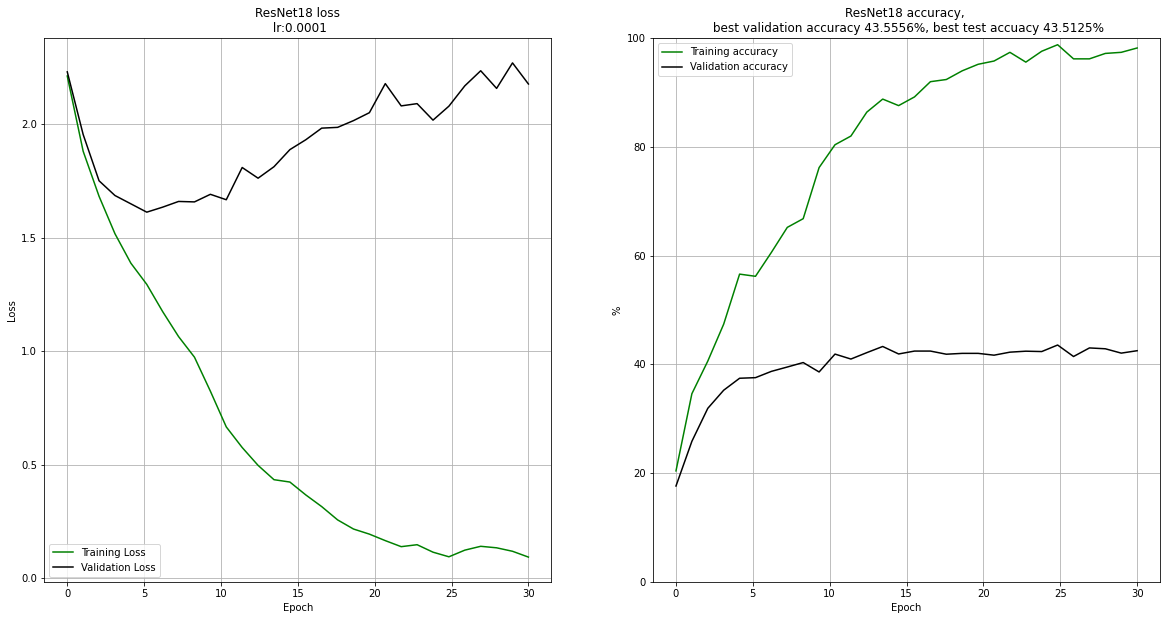

In [12]:
# Plot loss and acc
# Loss plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
x = np.linspace(0, num_epochs, len(train_loss_history))
ax1.plot(x, train_loss_history, c = "g")
x = np.linspace(0, num_epochs, len(val_loss_history))
ax1.plot(x, val_loss_history, c = "k")
ax1.set_title(f'ResNet18 loss\n lr:{lr}')
ax1.legend(["Training Loss", "Validation Loss"])
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.grid(True)

# Acc plot
x = np.linspace(0, num_epochs, len(train_acc_history))
ax2.plot(x, train_acc_history, c = "g")
x = np.linspace(0, num_epochs, len(val_acc_history))
ax2.plot(x, val_acc_history, c = "k")
ax2.set_ylim([0, 100])
ax2.set_title(f'ResNet18 accuracy, \n best validation accuracy {best_acc:.04f}%, best test accuacy {best_test_acc:.04f}%')
ax2.legend(["Training accuracy", "Validation accuracy"])
ax2.set_ylabel("%")
ax2.set_xlabel("Epoch")
ax2.grid(True)

fig.savefig("figures/ResNet_baseLine.png")